In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import ahocorasick

import torch
from transformers import AutoTokenizer, MT5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS:

SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

NUM_OF_SPLITS = 20

ATTACHMENT_TOKEN = '▁<extra_id_1>'
LABEL_PREFIX_TOKEN = ATTACHMENT_TOKEN

USED_MODEL_NAME = 'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 150
ANSWER_MAX_LENGTH = 150
BATCH_SIZE = 8
EVAL_BATCH_SIZE = 64

ENABLE_LABEL_FIX = True

LOCAL_NUM_EPOCHS = 1

In [ ]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)

optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 5e-5, weight_decay = 0.01)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cuda:0


In [4]:

# FUNCTIONS:

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

def create_parallels (data_lst, labels_lst, with_dict = False):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)

            constructed_label = ''
            if with_dict:
                constructed_label += LABEL_PREFIX_TOKEN
                for term in terms:
                    constructed_label += SEP_TOKEN + term.strip ()
            else:
                for term in terms:
                    constructed_label += term.strip () + SEP_TOKEN

            parallel_label.append (constructed_label)
    return parallel_text, parallel_label


def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res


def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def make_attachment (text, dictionary_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += SEP_TOKEN + term
    return res

def attach_dictionary_foundings (texts, dictionary_terms):
    res_texts = []
    for text in tqdm (texts):
        res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])
    res -= set ([LABEL_PREFIX_TOKEN [1:]])
    if len (res) == 0: res |= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)
        fps_sum += len (predicted_set - true_set)
        fns_sum += len (true_set - predicted_set)

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [5]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
#print (df.head ())
#print ()
df_2 = pd.read_json ('test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
#print (df_2.head ())
#print ()

val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

train_data_lst = df ['text'].tolist ()
train_labels_lst = df ['label'].tolist ()
train_parallel_text, train_parallel_labels = create_parallels (train_data_lst, train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

all_train_terms = set ()
for line in train_parallel_labels:
    all_train_terms |= set (line.split (SEP_TOKEN))
all_train_terms -= set ([''])
all_train_terms -= set ([LABEL_PREFIX_TOKEN])
#print (f'Уникальных терминов во всём тренировочном наборе: {len (all_train_terms)}.\n')

val_parallel_text_new = val_parallel_text#attach_dictionary_foundings (val_parallel_text, all_train_terms)
test_parallel_text_new = test_parallel_text#attach_dictionary_foundings (test_parallel_text, all_train_terms)

val_data = tokenizer (val_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    
    replaced = replace_padding (val_labels)
    val_labels = replaced

    replaced = replace_padding (test_labels)
    test_labels = replaced

val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

In [6]:
num_passed_epochs = 0
view_at_loss = True

In [7]:
kf = KFold (n_splits = NUM_OF_SPLITS if NUM_OF_SPLITS > 1 else 2)

data = df ['text']
labels = df ['label']

test_indices = list (kf.split (data))

In [8]:
import numpy as np

if NUM_OF_SPLITS == 1:
    test_indices = [(0, np.concatenate ([test_indices [0] [1], test_indices [0] [0]]))]


In [9]:
import mlflow
import mlflow.pytorch
from transformers import AutoTokenizer, MT5ForConditionalGeneration

mlflow.set_tracking_uri ('http://127.0.0.1:5000')
mlflow.set_experiment ('Foldlearner')

with mlflow.start_run ():
    mlflow.log_params ({
        'model_name':        USED_MODEL_NAME,
        'seq_max_length':    SEQ_MAX_LENGTH,
        'answer_max_length': ANSWER_MAX_LENGTH,
        'batch_size':        BATCH_SIZE,
        'num_splits':        NUM_OF_SPLITS,
        'num_local_epochs':  LOCAL_NUM_EPOCHS,
        'learning_rate':     1e-4,
        'weight_decay':      0.01
    })

    kf = KFold (n_splits = NUM_OF_SPLITS)

    data = df ['text']
    labels = df ['label']

    inc_term_set = set ([''])
    for iteration, (train_index, test_index) in enumerate (kf.split (data)):
        X_curr = data [test_index]
        y_curr = labels [test_index]

        train_data_lst = X_curr.tolist ()
        train_labels_lst = y_curr.tolist ()
        parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

        parallel_text_new = parallel_text#attach_dictionary_foundings (parallel_text, inc_term_set)

        train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
        train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
        
        if ENABLE_LABEL_FIX:
            replaced = replace_padding (train_labels)
            train_labels = replaced

        train_dataset = Seq2SeqDataset (train_data, train_labels)
        train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

        for epoch in range (LOCAL_NUM_EPOCHS):
            model.train ()
            total_loss = 0
            
            for batch in tqdm (train_loader):
                
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
                loss = outputs.loss
                total_loss += loss.item ()

                loss.backward ()
                optimizer.step ()
                optimizer.zero_grad ()

                torch.cuda.empty_cache ()
            

            avg_loss = total_loss / len (train_loader)

            metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_loss))

            model.eval ()
            val_preds, val_labels = [], []
            total_val_loss = 0

            with torch.no_grad ():
                for batch in val_loader:
                    input_ids = batch ['input_ids'].to (model.device)
                    attention_mask = batch ['attention_mask'].to (model.device)
                    labels_fromdata = batch ['labels'].to (model.device)

                    outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

                    total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                    val_preds.extend (outputs)
                    val_labels.extend (labels_fromdata)
                    torch.cuda.empty_cache ()

            avg_val_loss = total_val_loss / len (val_loader)

            prec, recl, f1sc = sanity_check (val_preds, val_labels)

            metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, avg_val_loss))
            metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, prec))
            metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, recl))
            metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs, f1sc))

            mlflow.log_metrics ({
                'epoch_train_loss': avg_loss,
                'val_loss':  avg_val_loss,
                'precision': prec,
                'recall':    recl,
                'f1_score':  f1sc
            }, epoch + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs)

            print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS + num_passed_epochs} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS + num_passed_epochs}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
            
            torch.cuda.empty_cache ()

    mlflow.log_dict (metrics, 'metrics.json')

2025/05/27 22:00:29 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

100%|██████████| 30/30 [00:04<00:00,  6.93it/s]


Epoch 1 / 20, Loss: 3.2586, Validation loss: 2.5220, 0.0033613445378151263 / 0.000836470096194061 / 0.0013395847287340924


100%|██████████| 30/30 [00:03<00:00,  7.76it/s]


Epoch 2 / 20, Loss: 2.1831, Validation loss: 2.0740, 0.029216467463479414 / 0.009201171058134672 / 0.013994910941475825


100%|██████████| 32/32 [00:04<00:00,  7.74it/s]


Epoch 3 / 20, Loss: 2.0608, Validation loss: 1.7959, 0.14986853637160386 / 0.07151819322459223 / 0.09682899207248018


100%|██████████| 35/35 [00:04<00:00,  7.94it/s]


Epoch 4 / 20, Loss: 1.8871, Validation loss: 1.5669, 0.2749812171299775 / 0.15307402760351319 / 0.19666845781837722


100%|██████████| 33/33 [00:04<00:00,  7.75it/s]


Epoch 5 / 20, Loss: 1.6849, Validation loss: 1.3596, 0.35110844817255843 / 0.2450857381848599 / 0.2886699507389163


100%|██████████| 23/23 [00:03<00:00,  7.52it/s]


Epoch 6 / 20, Loss: 1.3403, Validation loss: 1.2521, 0.38114517061885483 / 0.27561689669594314 / 0.31990291262135917


100%|██████████| 25/25 [00:03<00:00,  7.82it/s]


Epoch 7 / 20, Loss: 1.2950, Validation loss: 1.1428, 0.3894952251023192 / 0.23881221246340442 / 0.2960850401866736


100%|██████████| 22/22 [00:02<00:00,  7.69it/s]


Epoch 8 / 20, Loss: 1.1922, Validation loss: 1.0891, 0.4171392564587272 / 0.27687160184023424 / 0.33283056812468576


100%|██████████| 21/21 [00:02<00:00,  7.80it/s]


Epoch 9 / 20, Loss: 1.1452, Validation loss: 1.0526, 0.42732376793512167 / 0.2864910079464659 / 0.343014521782674


100%|██████████| 22/22 [00:02<00:00,  7.57it/s]


Epoch 10 / 20, Loss: 1.1428, Validation loss: 1.0386, 0.42305475504322765 / 0.3069845253032204 / 0.35579253514299564


100%|██████████| 19/19 [00:02<00:00,  7.48it/s]


Epoch 11 / 20, Loss: 1.0407, Validation loss: 1.0027, 0.436046511627907 / 0.3136762860727729 / 0.36487472634395524


100%|██████████| 22/22 [00:02<00:00,  7.58it/s]


Epoch 12 / 20, Loss: 1.1876, Validation loss: 0.9935, 0.42422596414991853 / 0.32664157256378085 / 0.3690926275992439


100%|██████████| 21/21 [00:02<00:00,  7.91it/s]


Epoch 13 / 20, Loss: 1.1573, Validation loss: 0.9378, 0.43930991990141716 / 0.29820158929318274 / 0.35525660189337327


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


Epoch 14 / 20, Loss: 1.0882, Validation loss: 0.9377, 0.43591160220994474 / 0.3299874529485571 / 0.37562485122589856


100%|██████████| 21/21 [00:02<00:00,  7.70it/s]


Epoch 15 / 20, Loss: 1.0873, Validation loss: 0.9186, 0.45465761875385563 / 0.3082392304475115 / 0.36739780658025917


100%|██████████| 27/27 [00:03<00:00,  7.36it/s]


Epoch 16 / 20, Loss: 1.0311, Validation loss: 0.9085, 0.48367459878251245 / 0.36553743203680467 / 0.41638875655073837


100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


Epoch 17 / 20, Loss: 0.9704, Validation loss: 0.8542, 0.5 / 0.34044332915098285 / 0.4050758895247574


100%|██████████| 33/33 [00:04<00:00,  7.52it/s]


Epoch 18 / 20, Loss: 1.0502, Validation loss: 0.8432, 0.5151898734177215 / 0.34044332915098285 / 0.4099722991689751


100%|██████████| 33/33 [00:04<00:00,  7.64it/s]


Epoch 19 / 20, Loss: 0.9622, Validation loss: 0.8448, 0.4924958310172318 / 0.3705562526139691 / 0.42291169451073984


100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


Epoch 20 / 20, Loss: 0.9802, Validation loss: 0.8327, 0.4925943621595795 / 0.43120033458803847 / 0.45985727029437995
🏃 View run gregarious-snipe-195 at: http://127.0.0.1:5000/#/experiments/1/runs/0230b33d2287444d890eac6827b9c18c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [10]:
print (metrics)

{'train_loss': [(0, 3.258588981628418), (1, 2.1831154425938926), (2, 2.060788732022047), (3, 1.8870851278305054), (4, 1.6849064176732844), (5, 1.3402639912522358), (6, 1.2949741625785827), (7, 1.1922168867154554), (8, 1.1451694454465593), (9, 1.1427796997807242), (10, 1.0407215325455916), (11, 1.187559195540168), (12, 1.157267349106925), (13, 1.0881805568933487), (14, 1.0872973515873863), (15, 1.031088285975986), (16, 0.9703630674630404), (17, 1.0502327554153674), (18, 0.9622425545345653), (19, 0.9801978528499603)], 'val_loss': [(0, 2.5220135688781737), (1, 2.0740102529525757), (2, 1.7959129095077515), (3, 1.56691871881485), (4, 1.3595644593238831), (5, 1.2520643591880798), (6, 1.1427536129951477), (7, 1.089127242565155), (8, 1.0526462972164154), (9, 1.0386201918125153), (10, 1.0026706993579864), (11, 0.9934927940368652), (12, 0.937807583808899), (13, 0.937746673822403), (14, 0.918605774641037), (15, 0.9085098385810852), (16, 0.8541723430156708), (17, 0.8431899189949036), (18, 0.844831

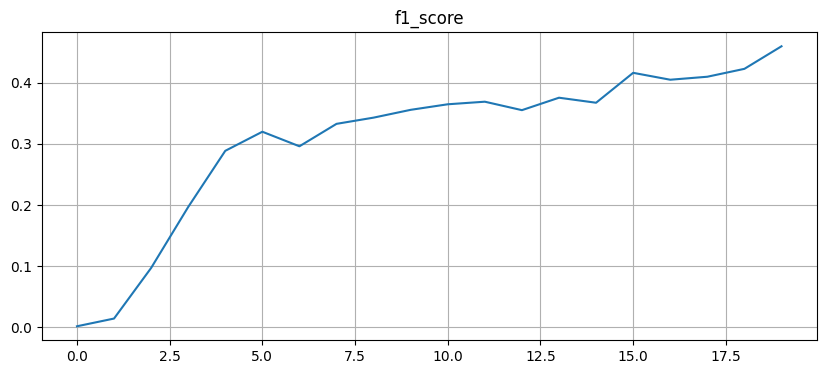

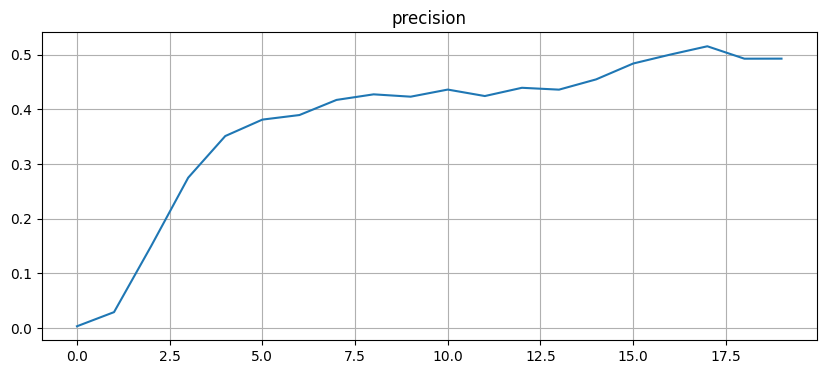

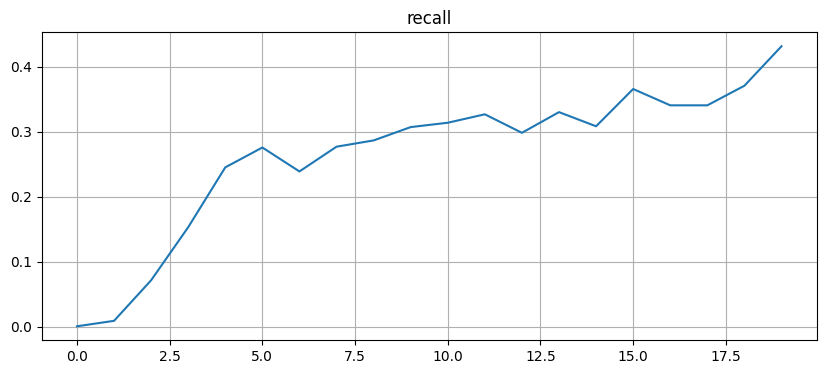

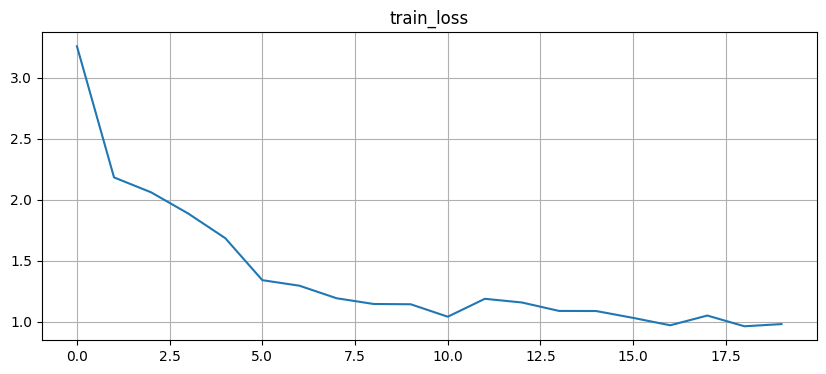

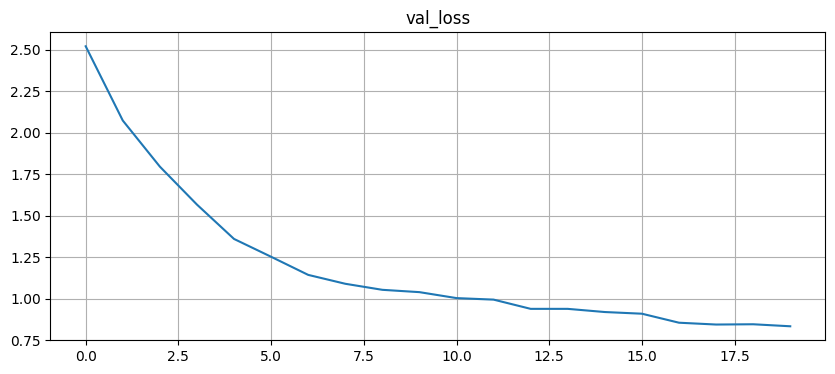

In [11]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.savefig (f'./images/{name}_plot.png')
    mlflow.log_artifact (f'./images/{name}_plot.png')
    plt.show ()
    

In [12]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

final_val_f1 = sanity_check (val_preds, val_labels_fromdata) [2]
print ('Validation wmax: ', final_val_f1)

mlflow.log_metric ('final_val_f1', final_val_f1)

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

final_test_f1 = sanity_check (val_preds, val_labels_fromdata) [2]
print ('Validation wmax: ', final_test_f1)

mlflow.log_metric ('final_test_f1', final_test_f1)


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Validation wmax:  0.45985727029437995


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


Validation wmax:  0.5012175324675325
